In [5]:
%matplotlib inline
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
# Helper Functions
from helpers import *

In [6]:
def crop(image, x1, x2, y1, y2):
    height = image.shape[0]
    width = image.shape[1]
    cropped = image[y1:y2, x1:x2]
    return cropped.copy()


def flip_img(img, direction):
    return cv2.flip(img, direction).copy()


def resize_with_pad(image, height=1500, width=1500):

    def get_padding_size(image):
        try:
            h, w, _ = image.shape
        except:
            h, w = image.shape
        longest_edge = max(h, w)
        top, bottom, left, right = (0, 0, 0, 0)
        if h < longest_edge:
            dh = longest_edge - h
            top = dh // 2
            bottom = dh - top
        elif w < longest_edge:
            dw = longest_edge - w
            left = dw // 2
            right = dw - left
        else:
            pass
    
        return top+100, bottom+100, left+100, right+100

    top, bottom, left, right = get_padding_size(image)
    BLACK = [0, 0, 0]
    constant = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=BLACK)

    resized_image = cv2.resize(constant, (height, width))

    return resized_image

def get_contours(image, image_thres):
    image_with_cnts = image.copy()

#     image_thres = cv2.erode(image_thres, None, iterations=2)
#     image_thres = cv2.dilate(image_thres, None, iterations=2)

    cnts = cv2.findContours(image_thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[1]
    cv2.drawContours(image_with_cnts, cnts, -1, (0, 255, 255), 5)

    return image_with_cnts, cnts


def crop_by_contour(image, cnts):
    min_area = 30000
    max_area = 2000000
    box = np.zeros(shape=image.shape, dtype="uint8")
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area and area < max_area:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(img=box,
                          pt1=(x, y),
                          pt2=(x + w, y + h),
                          color=(255, 255, 255),
                          thickness=-1)

    boxed = cv2.bitwise_and(src1=image, src2=box)
    image_cropped = image[y:y+h, x:x+w]

    return box, boxed, image_cropped

In [10]:
def remove_bg_block(image):
    image_thres = adaptive_thresholding_block(image)

    # Copy the thresholded image.
    im_floodfill = image_thres.copy()

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = image_thres.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);
    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    # Combine the two images to get the foreground.
    image_thres_filled = image_thres | im_floodfill_inv

    image_thres_bw = cv2.merge(mv=[image_thres_filled, image_thres_filled, image_thres_filled])
    # Use the mask to select the remove background
    image_noBg = cv2.bitwise_and(src1=image, src2=image_thres_bw)

    # Display images.
    # show1img("image", image)
    # show1img("crop", image)
#     show1img("gray", image_gray)
    # show1img("Thresholded Image", image_thres)
    # show1img("Floodfilled Image", im_floodfill)
    # show1img("Inverted Floodfilled Image", im_floodfill_inv)
    # show1img("Filled image", image_thres_filled)
#     show1img("RGB Thresholded image", image_thres_bw)
#     show2img("image", image, "Removed background", image_noBg)
    return image_noBg, image_thres

def remove_bg_slide(image):

    image_thres =  adaptive_thresholding_slide(image)

    image_thres_bw = cv2.merge(mv=[image_thres, image_thres, image_thres])
    # Use the mask to select the remove background
    image_noBg = cv2.bitwise_and(src1=image, src2=image_thres_bw)

    # Display images.
#     show1img("image", image)
#     show1img("gray", image_gray)
#     show1img("Thresholded Image", image_thres)
#     show1img("RGB Thresholded image", image_thres_bw)
#     show2img("image", image, "Removed background", image_noBg)
    return image_noBg, image_thres

def adaptive_thresholding_block(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    k = 9
    blur = cv2.GaussianBlur(src=image_gray, ksize=(k, k), sigmaX=0)
#     perform adaptive thresholding
    (t, image_thres) = cv2.threshold(src=blur, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#     (t, image_thres) = cv2.threshold(src=blur, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
#     image_thres = cv2.erode(image_thres, None, iterations=10)
#     image_thres = cv2.dilate(image_thres, None, iterations=1)
    image_thres =  cv2.bitwise_not(image_thres)
    
    return image_thres

def adaptive_thresholding_slide(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    k = 13
    blur = cv2.GaussianBlur(src=image_gray, ksize=(k, k), sigmaX=0)
#     perform adaptive thresholding
#     (t, image_thres) = cv2.threshold(src=blur, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    (t, image_thres) = cv2.threshold(src=blur, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
#     image_thres = cv2.erode(image_thres, None, iterations=10)
#     image_thres = cv2.dilate(image_thres, None, iterations=1)
    image_thres =  cv2.bitwise_not(image_thres)
    
    return image_thres

def find_crop_origin(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for x in range(image.shape[1]-1,  0, -1):
        for y in range(1000, image.shape[0]-1):
            if image[y][x][0] > 300 or image[y][x][0] < 30:
#                 print((y,x))
#                 print(image[y][x][0])
#                 image[y,x] = [0,0,255]
#                 show1img('image', image)
#                 show1img('zoom', crop(image, x-100, x+100, y-100, y+100))
                return (y,x)

def fill_small_long_contour(image, cnts):
    
    min_area = 20*20
    elon_ratio = 8
    for c in cnts:
        if cv2.contourArea(c) < min_area:
#             rect  = cv2.minAreaRect(c)
#             box = cv2.boxPoints(rect)
#             box = np.int0(box)
#             image = cv2.drawContours(image,[box],0,(255,0,0),2)
            cv2.fillPoly(img=image, pts =[c], color=(0,0,0))
                
#         (x,y),(w,h),r = cv2.minAreaRect(c)
#         if h!=0 and w!=0: 
#             if h/w > elon_ratio or w/h > elon_ratio:
# #                 rect  = cv2.minAreaRect(c)
# #                 box = cv2.boxPoints(rect)
# #                 box = np.int0(box)
# #                 image = cv2.drawContours(image,[box],0,(0,0,255),2)
#                 cv2.fillPoly(img=image, pts =[c], color=(0,0,0))
        
        else: 
            image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)            
            mask = np.zeros(image_hsv.shape[:2], np.uint8)
            cv2.drawContours(mask, [c], -1, 255, -1)
            mean_colour = cv2.mean(image_hsv, mask=mask)
            if mean_colour[0] < 90 or mean_colour[0] > 170 :
    #             rect  = cv2.minAreaRect(c)
    #             box = cv2.boxPoints(rect)
    #             box = np.int0(box)
    #             image = cv2.drawContours(image,[box],0,(0,255,0),2)
                cv2.fillPoly(img=image, pts =[c], color=(0,0,0))

def resize(image):

    positions = np.nonzero(image)

    y1 = positions[0].min()
    y2 = positions[0].max()
    x1 = positions[1].min()
    x2 = positions[1].max()
                
#     print(x1,x2,y1,y2)           
    image_crop = crop(image, x1, x2, y1, y2)
    
    image_resize = resize_with_pad(image_crop, height=1500, width=1500)
#     show1img('original', image)
#     show1img('image_crop', image_crop)
#     show1img('image_resize', image_resize)
    
    return image_resize

In [15]:
path = './img_raw/slides/'
files = os.listdir(path)
for index, file in enumerate(files):
    print(file)
    # convert image from BGR to RGB
    img = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    (y,x) = find_crop_origin(img)
    image_crop = crop(img, x-2620, x-450, y-1180, y-120)
    image_noBg_nofill, image_thres = remove_bg_slide(image_crop)
    image_with_cnts, cnts = get_contours(image_noBg_nofill, image_thres)
    fill_small_long_contour(image_noBg_nofill, cnts)
    image_resize = resize(image_noBg_nofill)
    cv2.imwrite(f'./img_clean/slides_nobg/{file[:-4]}_nobg.jpg', cv2.cvtColor(image_resize, cv2.COLOR_RGB2BGR))

slide_0.jpg
slide_1.jpg
slide_10.jpg
slide_11.jpg
slide_12.jpg
slide_13.jpg
slide_14.jpg
slide_15.jpg
slide_16.jpg
slide_17.jpg
slide_18.jpg
slide_19.jpg
slide_2.jpg
slide_20.jpg
slide_21.jpg
slide_22.jpg
slide_23.jpg
slide_3.jpg
slide_4.jpg
slide_5.jpg
slide_6.jpg
slide_7.jpg
slide_8.jpg
slide_9.jpg


In [17]:
path = './img_raw/blocks/'
files = os.listdir(path)
for index, file in enumerate(files):
    print(file)
    # convert image from BGR to RGB
    img = cv2.cvtColor(cv2.imread(os.path.join(path, file)), cv2.COLOR_BGR2RGB)
    img_crop = crop(img, 1250, 2950, 1130, 2450)
    # show2img('img',img,'img_crop',img_crop)
    image_noBg, image_thres = remove_bg_block(img_crop)
    image_with_cnts, cnts = get_contours(image_noBg, image_thres)
    image_resize = resize(image_noBg)
    cv2.imwrite(f'./img_clean/blocks_nobg/{file[:-4]}_nobg.jpg', cv2.cvtColor(image_resize, cv2.COLOR_RGB2BGR))

block_0.JPG
block_1.JPG
block_10.JPG
block_11.JPG
block_12.JPG
block_13.JPG
block_14.JPG
block_15.JPG
block_16.JPG
block_17.JPG
block_18.JPG
block_19.JPG
block_2.JPG
block_20.JPG
block_21.JPG
block_22.JPG
block_23.JPG
block_3.JPG
block_4.JPG
block_5.JPG
block_6.JPG
block_7.JPG
block_8.JPG
block_9.JPG


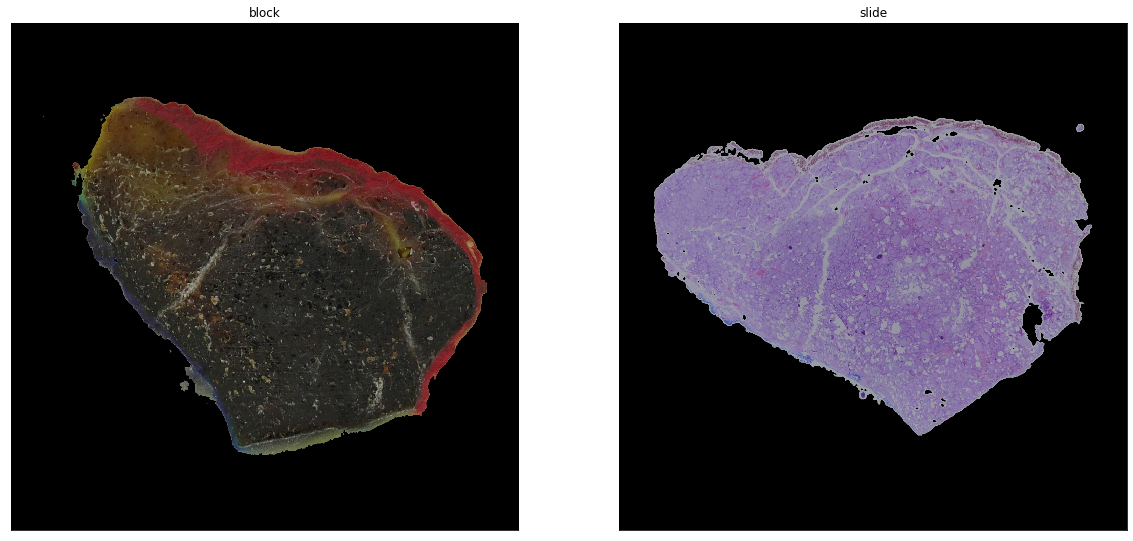

In [73]:
image_block = cv2.cvtColor(cv2.imread(os.path.join('./img_clean/blocks_nobg/', 'block_2_nobg.jpg')), cv2.COLOR_BGR2RGB)
image_slide = cv2.cvtColor(cv2.imread(os.path.join('./img_clean/slides_nobg/', 'slide_2_nobg.jpg')), cv2.COLOR_BGR2RGB)

show2img('block',image_block,'slide',image_slide)

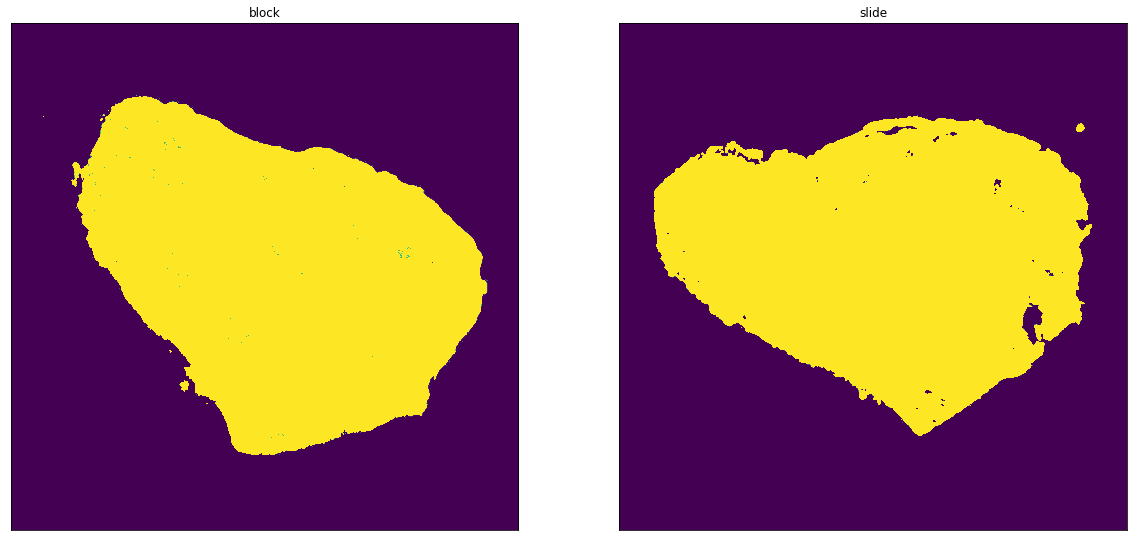

In [74]:
image_thres_block = image_block.copy()
image_thres_block[image_thres_block > 5] = 255

image_thres_slide = image_slide.copy()
image_thres_slide[image_thres_slide > 5] = 255

ref = cv2.cvtColor(image_thres_block,cv2.COLOR_BGR2GRAY)
mov = cv2.cvtColor(image_thres_slide,cv2.COLOR_BGR2GRAY)

show2img( 'block', ref, 'slide', mov)

In [75]:
from pystackreg import StackReg

#Translational transformation
sr = StackReg(StackReg.TRANSLATION)
out_tra = sr.register_transform(ref, mov)

#Rigid Body transformation
sr = StackReg(StackReg.RIGID_BODY)
out_rot = sr.register_transform(ref, mov)

#Scaled Rotation transformation
sr = StackReg(StackReg.SCALED_ROTATION)
out_sca = sr.register_transform(ref, mov)

#Affine transformation
sr = StackReg(StackReg.AFFINE)
out_aff = sr.register_transform(ref, mov)

#Bilinear transformation
sr = StackReg(StackReg.BILINEAR)
out_bil = sr.register_transform(ref, mov)

out_tra = out_tra.astype(np.uint8)
out_rot = out_rot.astype(np.uint8)
out_sca = out_sca.astype(np.uint8)
out_aff = out_aff.astype(np.uint8)
out_bil = out_bil.astype(np.uint8)

In [76]:
def superimpose(img_block, img_slide):

    img_block = cv2.cvtColor(img_block, cv2.COLOR_GRAY2RGB)
    img_slide = cv2.cvtColor(img_slide, cv2.COLOR_GRAY2RGB)

    img_sub_block_slide = cv2.subtract(img_block, img_slide)

    img_sub_block_slide_coloured = img_sub_block_slide.copy()
    img_sub_block_slide_coloured[img_sub_block_slide_coloured[:, :, 2] > 10] = [
        0, 0, 255]

    img_sub_slide_block = cv2.subtract(img_slide, img_block)

    img_sub_slide_block_coloured = img_sub_slide_block.copy()
    img_sub_slide_block_coloured[img_sub_slide_block_coloured[:, :, 0] > 10] = [
        255, 0, 0]
    
#     show2img(img_sub_block_slide_coloured, 'block - slide',img_sub_slide_block_coloured, 'slide - block')

    img_diff = cv2.add(img_sub_block_slide, img_sub_slide_block)
    img_diff_coloured = cv2.add(
        img_sub_block_slide_coloured, img_sub_slide_block_coloured)

    img_add = cv2.add(img_block, img_slide)
    img_same = cv2.subtract(img_add, img_diff)
#     show2img(img_same, 'img_same', img_diff_coloured, 'img_diff')

    img = cv2.addWeighted(img_diff_coloured, 0.7, img_same, 0.5, 0)
    show1img('addWeighted', img)

    n_white_pix_add = np.sum(img_add[:, :, 0] == 255)
    n_white_pix_same = np.sum(img_same[:, :, 0] == 255)
    n_white_pix_diff = np.sum(img_diff[:, :, 0] == 255)
    score = 1 - n_white_pix_diff/n_white_pix_add
    
    print('=========== Superimpose ===========')
    print("Superimpose: %.2f" % score)

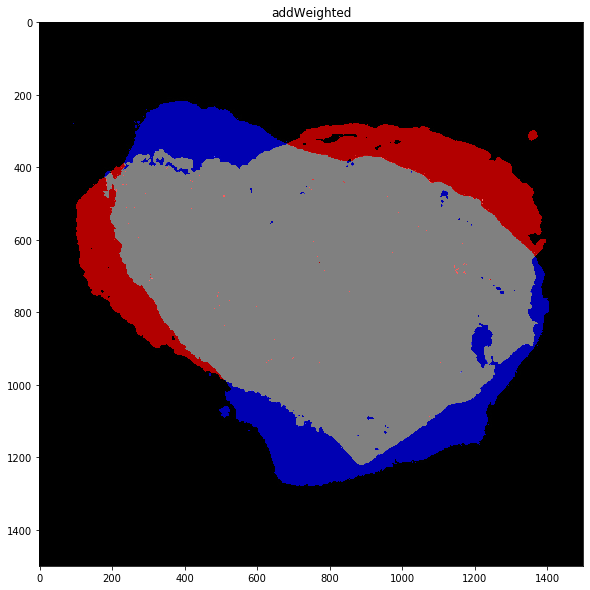

=========== Superimpose ===========
Superimpose: 0.73


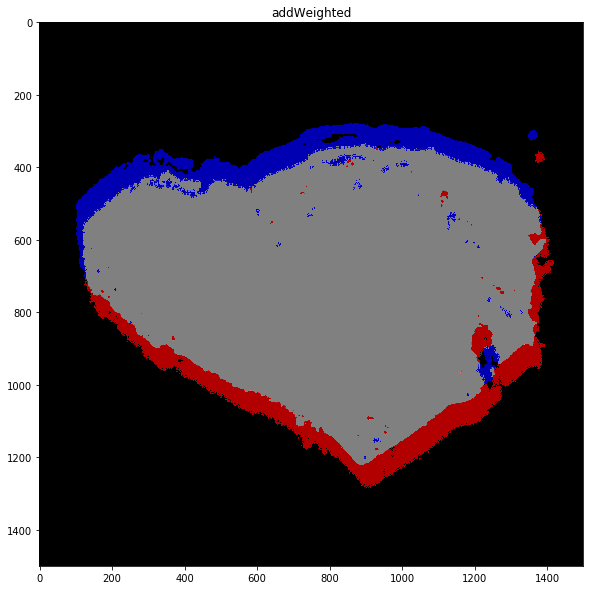

=========== Superimpose ===========
Superimpose: 0.85


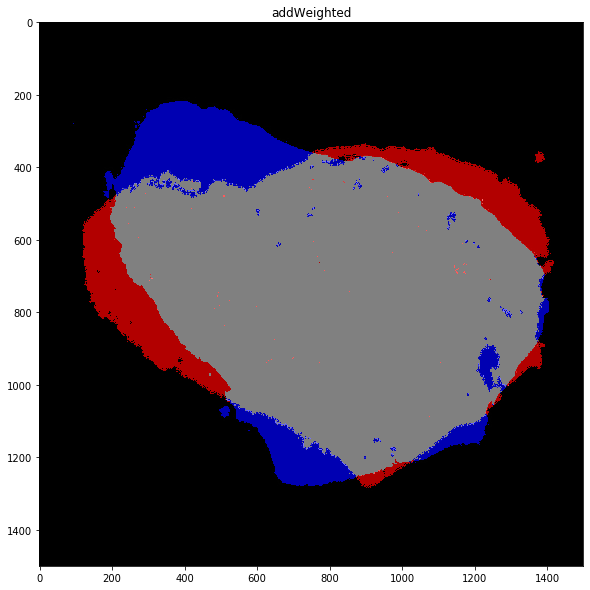

=========== Superimpose ===========
Superimpose: 0.77


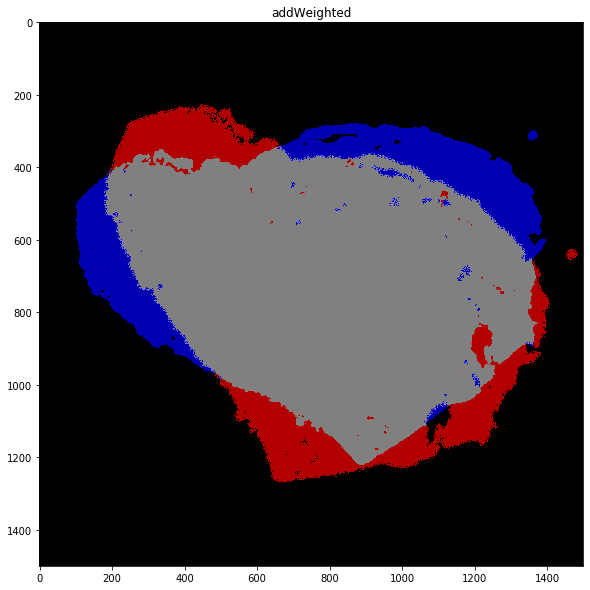

=========== Superimpose ===========
Superimpose: 0.74


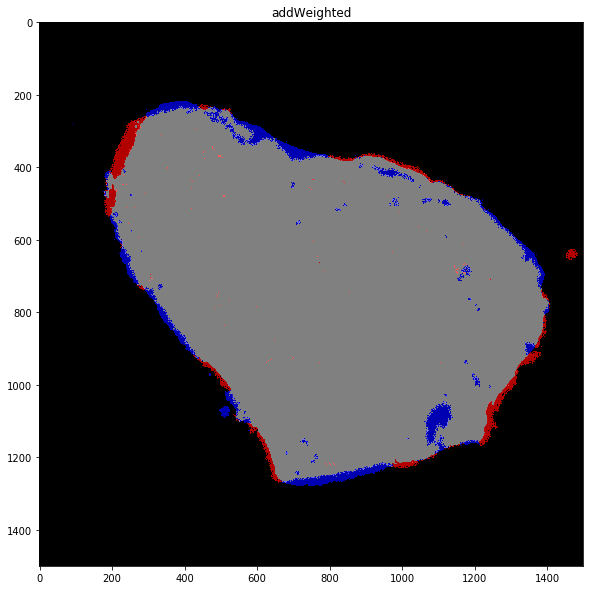

=========== Superimpose ===========
Superimpose: 0.97


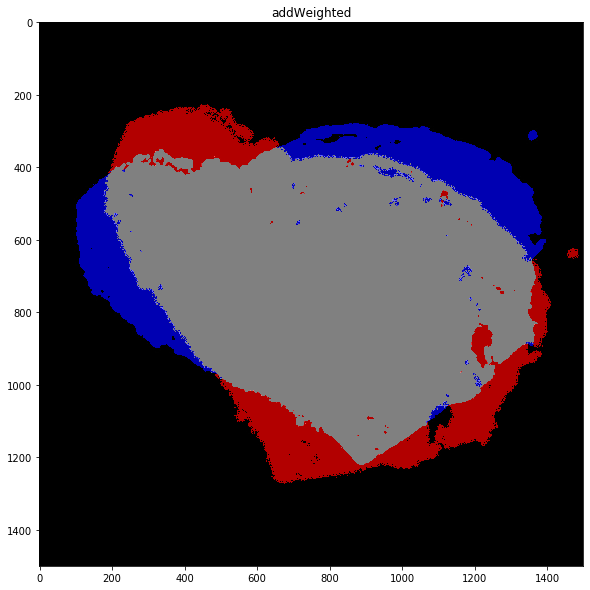

=========== Superimpose ===========
Superimpose: 0.74


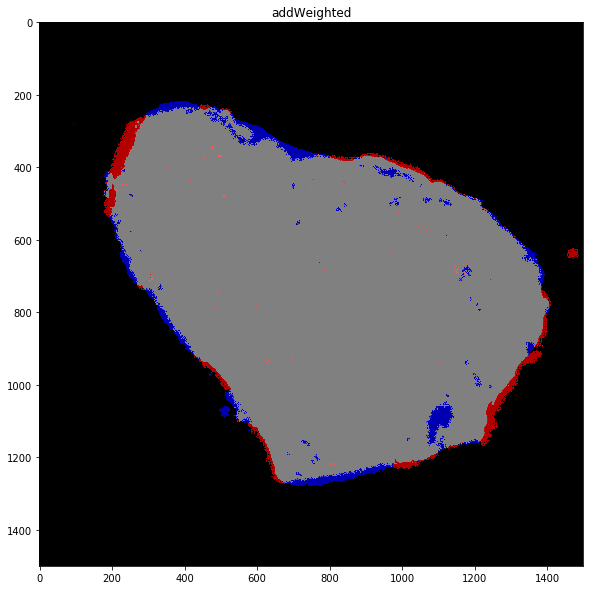

=========== Superimpose ===========
Superimpose: 0.97


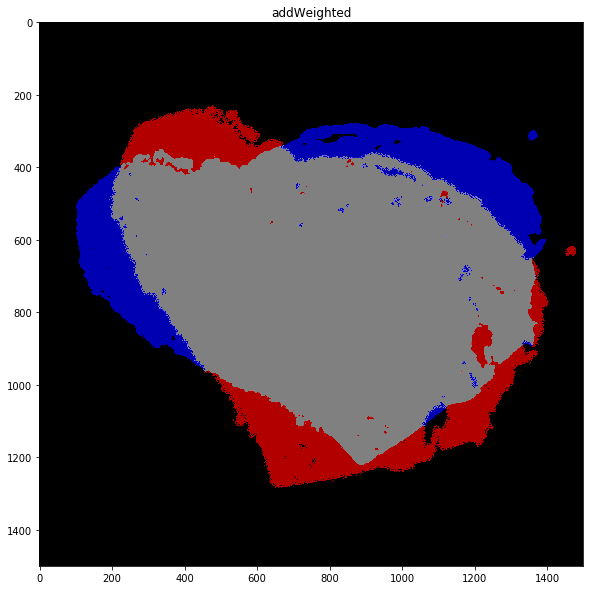

=========== Superimpose ===========
Superimpose: 0.74


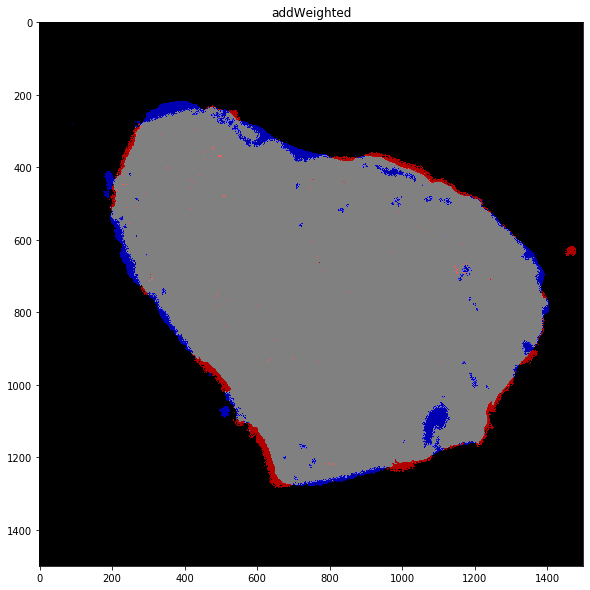

=========== Superimpose ===========
Superimpose: 0.97


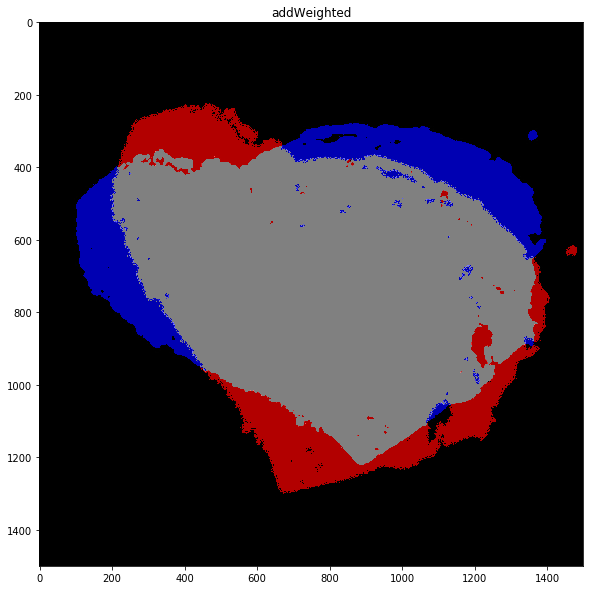

=========== Superimpose ===========
Superimpose: 0.74


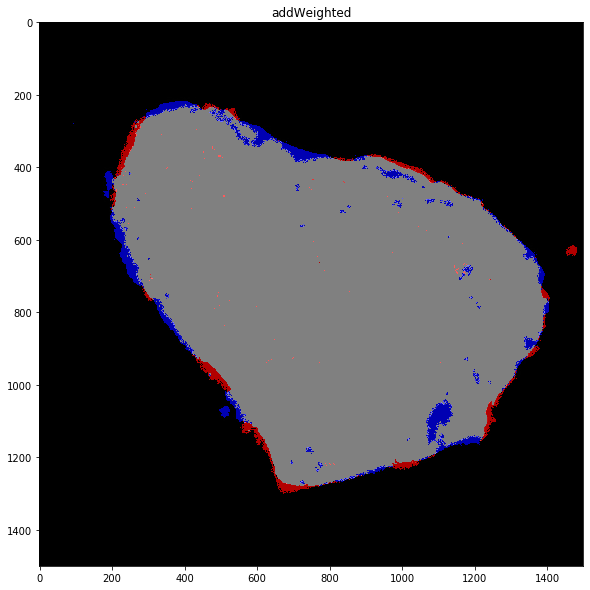

=========== Superimpose ===========
Superimpose: 0.97


In [77]:
superimpose(ref, mov)

superimpose(mov, out_tra)
superimpose(ref, out_tra)

superimpose(mov, out_rot)
superimpose(ref, out_rot)

superimpose(mov, out_sca)
superimpose(ref, out_sca)

superimpose(mov, out_aff)
superimpose(ref, out_aff)

superimpose(mov, out_bil)
superimpose(ref, out_bil)